CCDR Hazard Analysis Notebook
Deveoped by M. Amadio and T. Iwanaga

In [1]:
from common import *  # import necessary packages

%matplotlib inline

In [2]:
country_code_map = {
    "NPL": 175,
    "PAK": 188,
    "BGD": 23,
    "GHA": 94
}

In [3]:
def damage_factor_builtup(x):
    """A polynomial fit to average damage across builtup land cover relative 
    to water depth in meters in Asia.

    The sectors are commercial, industry, transport, infrastructure and residential.

    Values are capped between 0 and 1, where values >= 6m = 1

    References
    ----------
    .. [1] JRC, 2017
    """
    return np.maximum(0.0, np.minimum(1.0, 0.00723*x**3 - 0.1*x**2 + 0.506*x))

In [4]:
def damage_factor_agri(x):
    """A polynomial fit to average damage across agricultural land cover relative 
    to water depth in meters in Asia.

    Values are capped between 0 and 1, where values >= 6m = 1

    References
    ----------
    .. [1] JRC, 2017
    """
    return np.maximum(0.0, np.minimum(1.0, 0.00723*x**3 - 0.1*x**2 + 0.506*x))


In [5]:
def mortality_factor(x):
    """A polynomial fit to average population mortality due to nearby flooding.
    References
    ----------
    .. [1] Jonkman et al, 2008
    """
    return np.maximum(0.0, np.minimum(1.0, 0.985/(1+np.exp(6.32-1.412*x))))

In [6]:
def preview_impact_func(bt):
    
    if exp_cat_dd.value == 'pop':
        damage_factor = mortality_factor
    elif exp_cat_dd.value == 'builtup':
        damage_factor = damage_factor_builtup
    elif exp_cat_dd.value == 'agri':
        damage_factor = damage_factor_agri
    else:
        ValueError("Unknown exposure category")
    
    steps = np.arange(0, 6, 0.1)
    with output:
        output.clear_output()

        fig, ax = plt.subplots()
        line, = ax.plot([damage_factor(x) for x in steps])
        ax.grid(True)
        
        label_steps = range(0, len(steps)+10, 10)
        ax.xaxis.set_ticks(label_steps)
        ax.xaxis.set_ticklabels([i / 10 for i in label_steps])
        ax.set_xlabel("Hazard intensity")
        ax.set_ylabel("Impact Factor")
        
        display(fig)

In [7]:
def run_analysis(rb):
    with output:
        output.clear_output()
        print("Running analysis...")
        rb.disabled = True
        preview_impact_button.disabled = True

    # Get user input
    country = country_dd.value
    exp_cat = exp_cat_dd.value
    time_horizon = time_horizon_dd.value
    rcp_scenario = rcp_scenario_dd.value

    target_ADM = adm_dd.value
    adm_name = target_ADM.replace('_', '')

    min_haz_threshold = min_haz_slider.value

    valid_RPs = [10, 100, 1000]

    # Testing data file locations
    # TODO: Temp data store, to be replaced with a config spec (.env file?) before deployment
        
    if exp_cat_dd.value == 'pop':
        damage_factor = mortality_factor
        try:
            exp_ras = f"{DATA_DIR}/EXP/{country}_WPOP20.tif"
        except ValueError:
        # TODO: Download from website if layer not available
            exp_ras = f"{DATA_DIR}/EXP/WorldPop20_{country}_ppp_UNadj_constrained.tif"
    elif exp_cat_dd.value == 'builtup':
        damage_factor = damage_factor_builtup
        exp_ras = f"{DATA_DIR}/EXP/{country}_WSF19.tif"
    elif exp_cat_dd.value == 'agri':
        damage_factor = damage_factor_agri
        exp_ras = f"{DATA_DIR}/EXP/{country}_ESA20_agri.tif"
    else:
        ValueError("Missing data layer")
     
          
    # Flood data location (TODO: replace with pointer to downloaded data store)
    flood_RP_data_loc = f"{DATA_DIR}/HZD"

    # Load or save ISO3 country list
    iso3_path = os.path.join(DATA_DIR, "cache/iso3.json")
    if not os.path.exists(iso3_path):
        resp = json.loads(requests.get(f"https://www.worldpop.org/rest/data/pop/wpgp?iso3={country}").text)

        with open(iso3_path, 'w') as outfile:
            json.dump(resp, outfile)
    else:
        with open(iso3_path, 'r') as infile:
            resp = json.load(infile)


    # TODO: Download WorldPop data from API if the layer is not found (see except before)
    # Target population data files are extracted from the JSON list downloaded above
    metadata = resp['data'][1]
    data_src = metadata['files']

    # Save population data to cache location
    for data_fn in tqdm(data_src):
        fid = metadata['id']
        cache_fn = os.path.basename(data_fn)

        # Look for indicated file in cache directory
        # Use the data file if it is found, but warn the user. 
        # (if data is incorrect or corrupted, they should delete it from cache)
        if f"{fid}_{cache_fn}" in os.listdir(CACHE_DIR):
            warnings.warn(f"Found {fid}_{cache_fn} in cache, skipping...")
            continue

        # Write to cache file if not found
        with open(os.path.join(CACHE_DIR, "{fid}_{cache_fn}"), "wb") as handle:
            response = requests.get(data_fn)
            handle.write(response.content)


    # Run analysis
    
    # Open exposure dataset
    exp_data = rxr.open_rasterio(exp_ras)

    # Indicate -1 values as representing no data.
    exp_data.rio.write_nodata(-1, inplace=True)

    # Load ADM2 based on country code value
    adm_dataset = gpd.read_file(os.path.join(DATA_DIR, f"ADM/{country}_ADM.gpkg"), layer=f"{country}_{adm_name}")
    adm_data = adm_dataset.loc[adm_dataset.ADM0_CODE == country_code_map[country], :]

    # Prep result structure
    exp_sum_cols = [f"RP{rp_i}_exp_tot" for rp_i in valid_RPs]
    EAI_cols = [f"RP{rp_i}_EAI" for rp_i in valid_RPs]
    
    # Get all ADM code/name columns to save with results
    adm_cols = adm_data.columns
    all_adm_codes = adm_data.columns.str.contains("_CODE")
    all_adm_names = adm_data.columns.str.contains("_NAME")
    
    all_adm_name_tmp = adm_cols[all_adm_names].tolist()
    all_adm_code_tmp = adm_cols[all_adm_codes].to_list()

    result_df = adm_data.loc[:, all_adm_code_tmp + all_adm_name_tmp + ["geometry"]]
    result_df.loc[:, exp_sum_cols + EAI_cols] = 0
         
    for rp in valid_RPs:
        
        # Get total exposure for each ADM region
        exp_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=exp_ras, stats=["sum"])
        
        result_df[f"{adm_name}_{exp_cat}"] = [x['sum'] for x in exp_per_ADM]

        # Load corresponding flood dataset
        flood_data = rxr.open_rasterio(os.path.join(flood_RP_data_loc, f"{country}_RP{rp}.tif"))

        # Reproject and clip raster to same bounds as exposure data
        flood_data = flood_data.rio.reproject_match(exp_data)

        # Get raw array values for exposure and hazard layer
        fld_array = flood_data[0].values
        fld_array[fld_array < min_haz_threshold] = np.nan  # Set values below min threshold to nan
        # fld_array[fld_array > max_haz_threshold] = max_haz_threshold  # Cap large values to maximum threshold value

        # Assign impact factor (this is F_i)
        # TODO: Change this function call to use the relevant function depending on `exp_cat_dd`
        if exp_cat_dd.value == 'pop':
            impact_array = mortality_factor(fld_array)
        elif exp_cat_dd.value == 'builtup':
            impact_array = damage_factor_builtup(fld_array)
        elif exp_cat_dd.value == 'agri':
            impact_array = damage_factor_agri(fld_array)
        
        # Create raster from array
        impact_rst = xr.DataArray(np.array([impact_array]).astype(np.float32), 
                                  coords=flood_data.coords, 
                                  dims=flood_data.dims)
        
        if save_inter_rst_chk.value:
            impact_rst.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{rp}_{exp_cat}_flood_imp_factor.tif"))

        # Calculate affected exposure in ADM        
        # Filter down to valid areas
        valid_impact_areas = impact_rst.values > 0
        affected_exp = exp_data.where(valid_impact_areas)  # Get total exposure in affected areas
        affected_exp = affected_exp.where(affected_exp > 0)  # Out of the above, get areas that have people
        
        if save_inter_rst_chk.value:
            affected_exp.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{rp}_{exp_cat}_flood_affected_.tif"))
        
        # Calculate degree on impact over Exposure category
        impact_exp = affected_exp * impact_rst.where(valid_impact_areas)  # Get impacted exposure in affected areas
        
        if save_inter_rst_chk.value:
            impact_exp.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{exp_cat}_{rp}_impact.tif"))
        
        impact_exp_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=impact_exp.data[0], 
                                             stats=["sum"], affine=impact_exp.rio.transform(), nodata=0)
        result_df[f"RP{rp}_{exp_cat}_imp"] = [x['sum'] for x in impact_exp_per_ADM]
        
        # Probability of return period
        # Essentially the same as 1/RP, but accounts for cases where RP == 1
        freq = 1 - np.exp(-1/rp)

        # EAI_i := F_i * freq
        EAI_i = impact_exp.where(valid_impact_areas) * freq
        

        if save_inter_rst_chk.value:
            # Save intermediate file if requested
            EAI_i.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{exp_cat}_{rp}_EAI.tif"))

        # Get affected exposure per ADM
        affected_exp_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=affected_exp.data[0], 
                                            stats=["sum"], affine=affected_exp.rio.transform(), nodata=0)
        result_df[f"RP{rp}_{exp_cat}_tot"] = [x['sum'] for x in affected_exp_per_ADM]


        EAI_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=EAI_i.data[0],
                                    stats=["sum"], affine=EAI_i.rio.transform(), nodata=0)
        result_df[f"RP{rp}_EAI"] = [x['sum'] for x in EAI_per_ADM]

    # Sum all EAI to get total EAI across all RPs
    result_df.loc[:, f"{exp_cat}_EAI"] = result_df.loc[:, result_df.columns.str.contains('_EAI')].sum(axis=1)

    # Calculate Exp_EAI% (Percent affected exposure per year)
    result_df.loc[:, f"{exp_cat}_EAI%"] = (result_df.loc[:, f"{exp_cat}_EAI"] / result_df.loc[:, f"{adm_name}_{exp_cat}"]) * 100.0

    # Round to two decimal places to avoid giving the impression of high precision
    result_df = result_df.round(3)
    
    # Reorder - need ADM code, name, and exp at the front regardless of ADM level
    # PLEASE CHECK: after turning "pop" parameter into variable {exp_cat} for output fields,
    # it resulted in duplicated fields for csv and gpkg output tables,
    # so I removed adm_exp from the result_df below (duplicated fields) and seems to work fine
    
    # cols = result_df.columns
    # adm_exp = cols.str.contains(f"_{exp_cat}")
    # adm_exp = cols[adm_exp].tolist()

    result_df = result_df.loc[:, all_adm_code_tmp + all_adm_name_tmp +
                              [f"{adm_name}_{exp_cat}", f"RP10_{exp_cat}_tot", f"RP100_{exp_cat}_tot", f"RP1000_{exp_cat}_tot",
                               f"RP10_{exp_cat}_imp", f"RP100_{exp_cat}_imp", f"RP1000_{exp_cat}_imp", 
                               "RP10_EAI", "RP100_EAI", "RP1000_EAI", f"{exp_cat}_EAI", f"{exp_cat}_EAI%", "geometry"]]

    # Write table of total population in each class, in each ADM2
    df_cols = result_df.columns
    result_df.loc[:, df_cols[~df_cols.isin(['geometry'])]].fillna(0).to_csv(os.path.join(OUTPUT_DIR, f"{country}_FL_{adm_name}_{exp_cat}_EAI.csv"), index=False)

    # Export geopackage
    result_df.to_file(os.path.join(OUTPUT_DIR, f"{country}_FL_{adm_name}_{exp_cat}_EAI.gpkg"))

    with output:
        print("Finished analysis.")
        rb.disabled = False
    
    if preview_chk.value:
        with output:
            display(result_df.explore(column=f'{exp_cat}_EAI', cmap='plasma'))

    

In [8]:
# Data option widgets
country_dd = widgets.Dropdown(
    options=[('Nepal', 'NPL'), ('Pakistan', 'PAK'),('Bangladesh', 'BGD'),('Ghana', 'GHA')],
    value='NPL',
    description='Country:',
    style= {'description_width': 'initial'}
)

exp_cat_dd = widgets.Dropdown(
    options=[("Population", "pop"), ("Built-up", "builtup"), ("Agriculture", "agri")],
    value='pop',
    description='Exposure Category:',
    style= {'description_width': 'initial'}
)

adm_dd = widgets.Dropdown(
    options=['ADM1', 'ADM2', 'ADM3'],
    value='ADM2',
    description='Administrative Unit Level:',
    style= {'description_width': 'initial'}
)

min_haz_slider = widgets.FloatSlider(
    value=0.5,
    min=0.01,
    max=10.0,
    step=0.01,
    description="Minimum hazard Threshold:",
    style= {'description_width': 'initial'}
)

# Climate component (in addition to baseline risk - load external module)

time_horizon_dd = widgets.Dropdown(
    options=[2040, 2060, 2080, 2100],
    value=2060,
    description='Time Horizon:',
    style= {'description_width': 'initial'}
)

rcp_scenario_dd = widgets.Dropdown(
    options=["2.6", "4.5", "8.5"],
    value="4.5",
    description='RCP Scenario:',
    style= {'description_width': 'initial'}
)

# User action widgets
save_inter_rst_chk = widgets.Checkbox(
    value=False,
    description='Export Intermediate Rasters',
    tooltip='Save rasters generated between each step (saves to nominated output directory)',
    disabled=False,
    indent=False
)

# Display results after runs
preview_chk = widgets.Checkbox(
    value=True,
    description='Preview results',
    tooltip='Display result after analysis',
    disabled=False
)


# Run button to perform analysis
run_button = widgets.Button(
    description='Run Analysis',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to run analysis with selected options',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)


# Button to preview hazard impact function
preview_impact_button = widgets.Button(
    description='Preview Impact Function',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Show preview of impact function',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)

reset_display_button = widgets.Button(
    description='Reset',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset display',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)


def reset_display(bt):
    output.clear_output()
    run_button.disabled = False
    preview_impact_button.disabled = False

run_button.on_click(run_analysis)
preview_impact_button.on_click(preview_impact_func)
reset_display_button.on_click(reset_display)

# preview_button.on_click()

# class_range = range(3, 11)  # remember that python uses end-exclusive range, so this is 3-10
# selected_bin_edges = [0.5, 1, 1.5, 2, 2.5, 3]
# min_haz_threshold = np.min(selected_bin_edges)  # determine min/max values from user-selected edges
# max_haz_threshold = np.max(selected_bin_edges)
# selected_bin_edges += [np.inf] # add inf last to cover anything above max threshold.

# num_bins = len(selected_bin_edges)-1  # default number of bins, within the range of `class_range`

Dropdown(description='Country:', options=(('Nepal', 'NPL'), ('Pakistan', 'PAK'), ('Bangladesh', 'BGD'), ('Ghan…

Dropdown(description='Exposure Category:', options=(('Population', 'pop'), ('Built-up', 'builtup'), ('Agricult…

Dropdown(description='Administrative Unit Level:', index=1, options=('ADM1', 'ADM2', 'ADM3'), style=Descriptio…

Dropdown(description='Time Horizon:', index=1, options=(2040, 2060, 2080, 2100), style=DescriptionStyle(descri…

Dropdown(description='RCP Scenario:', index=1, options=('2.6', '4.5', '8.5'), style=DescriptionStyle(descripti…

FloatSlider(value=0.5, description='Minimum hazard Threshold:', max=10.0, min=0.01, step=0.01, style=SliderSty…

Button(description='Preview Impact Function', style=ButtonStyle(), tooltip='Show preview of impact function')

Button(description='Reset', style=ButtonStyle(), tooltip='Reset display')

Output()

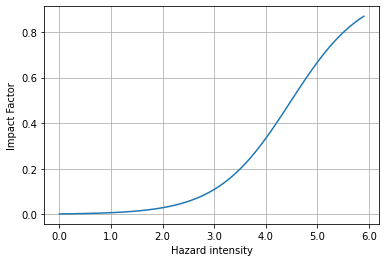

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.50s/it]


In [9]:
display(country_dd)
display(exp_cat_dd)
display(adm_dd)
display(time_horizon_dd)
display(rcp_scenario_dd)
display(min_haz_slider)

display(HBox([run_button, preview_chk, save_inter_rst_chk]), 
        preview_impact_button, reset_display_button)

output = widgets.Output()
display(output)